In [203]:
# Imports
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

### Data Preprocessing
We start by reading the different csv-files that contain the data.

In [204]:
# Define the folder path
data_path = "data/"

# Load datasets
zero_coupon = pd.read_csv(os.path.join(data_path, "zero_coupon_rates.csv"), delimiter=";")
exchange_rates = pd.read_csv(os.path.join(data_path, "usd_nok.csv"), delimiter=";")
inflation = pd.read_csv(os.path.join(data_path, "kpi.csv"), delimiter=";")
osebx = pd.read_csv(os.path.join(data_path, "osebx_prices.csv"), delimiter=";")

# Replace commas with dots in the KPI column and convert to float
inflation["kpi"] = inflation["kpi"].str.replace(",", ".").astype(float)


Then, we check for missing values in the data

In [205]:
datasets = {
    "OSEBX": osebx,
    "Zero Coupon": zero_coupon,
    "Exchange Rates": exchange_rates,
    "Inflation": inflation
}

for name, df in datasets.items():
    print(f"\nMissing Values in {name} Dataset:")
    print(df.isnull().sum())


Missing Values in OSEBX Dataset:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Missing Values in Zero Coupon Dataset:
FREQ           0
Frequency      0
TENOR          0
Tenor          0
DECIMALS       0
TIME_PERIOD    0
OBS_VALUE      0
dtype: int64

Missing Values in Exchange Rates Dataset:
FREQ                    0
Frequency               0
BASE_CUR                0
Base Currency           0
QUOTE_CUR               0
Quote Currency          0
TENOR                   0
Tenor                   0
DECIMALS                0
CALCULATED              0
UNIT_MULT               0
Unit Multiplier         0
COLLECTION              0
Collection Indicator    0
TIME_PERIOD             0
OBS_VALUE               0
dtype: int64

Missing Values in Inflation Dataset:
Date    0
kpi     0
dtype: int64


From the output, we can see that the data does not contain any null values.

Continue with converting the dates to Datetime format. Also, for inflation, since we are originally only having monthly data, we use forward-fill to get daily inflation data.

In [206]:
# Convert Date to Datetime format
osebx["Date"] = pd.to_datetime(osebx["Date"])
zero_coupon["TIME_PERIOD"] = pd.to_datetime(zero_coupon["TIME_PERIOD"])
exchange_rates["TIME_PERIOD"] = pd.to_datetime(exchange_rates["TIME_PERIOD"])
inflation["Date"] = pd.to_datetime(inflation["Date"], format="%YM%m")

# Create a full date range from the first to last available date in your dataset
full_date_range = pd.date_range(start=inflation["Date"].min(), end=inflation["Date"].max(), freq="D")

# Create a DataFrame with daily dates
inflation_daily = pd.DataFrame({"Date": full_date_range})

# Merge with the original inflation data (left join) and forward-fill missing values
inflation_daily = inflation_daily.merge(inflation, on="Date", how="left")
inflation_daily["kpi"] = inflation_daily["kpi"].ffill()

Compute log returns for OSEBX. Also, rename columns to ensure that all dataframes have a column named "Date", so that we can merge all datasets on "Date". After having merged all the datasets to one dataframe, we drop all the columns we are not interested in. Consequently, the columns we are left with are "Date", "kpi", "zero_coupon_rate", "usd_nok_exchange_rate", and "log_return".

In [207]:
# Compute log returns
osebx["log_return"] = np.log(osebx["Close"] / osebx["Close"].shift(1))
osebx.dropna(inplace=True)  # Drop the first row where return cannot be calculated

# Rename columns to "Date"
zero_coupon.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)
exchange_rates.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)

# Merge all datasets on 'Date'
df = inflation_daily.merge(zero_coupon, on="Date", how="inner")
df = df.merge(exchange_rates, on="Date", how="inner")
df = df.merge(osebx, on="Date", how="inner") 

df = df.drop(columns=["Close", "High", "Low", "Open", "Volume",
       "FREQ_x", "Frequency_x", "TENOR_x", "Tenor_x", "DECIMALS_x",
       "FREQ_y", "Frequency_y", "BASE_CUR", "Base Currency",
       "QUOTE_CUR", "Quote Currency", "TENOR_y", "Tenor_y", "DECIMALS_y",
       "CALCULATED", "UNIT_MULT", "Unit Multiplier", "COLLECTION",
       "Collection Indicator"])

df.rename(columns={"OBS_VALUE_x": "zero_coupon_rate"}, inplace=True)
df.rename(columns={"OBS_VALUE_y": "usd_nok_exchange_rate"}, inplace=True)

print(df.head())

        Date   kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return
0 2015-03-03  99.2             1.540                 7.7091    0.005967
1 2015-03-04  99.2             1.546                 7.7441   -0.012511
2 2015-03-05  99.2             1.567                 7.7207    0.011992
3 2015-03-06  99.2             1.639                 7.7917    0.002769
4 2015-03-09  99.2             1.676                 7.8992   -0.006572


Check for multicollinearity by computing the correlation matrix.

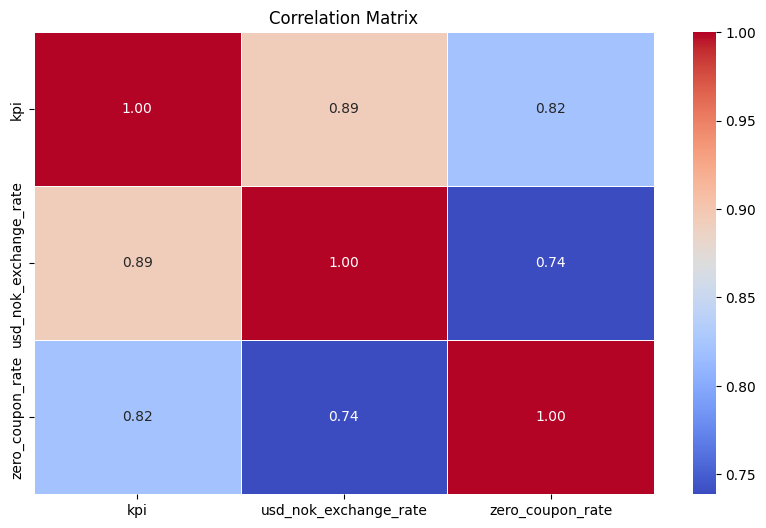

In [208]:
# Compute the correlation matrix
selected_columns = ["kpi", "usd_nok_exchange_rate", "zero_coupon_rate"]
corr_matrix = df[selected_columns].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

We define highly correlated values to have a correlation coefficient >0.9. Because all variables have a correlation coefficient below 0.9, we decide to keep all of the explanatory variables. However, we notice that especially between usd_nok_exchange_rate and kpi and between zero_coupon_rate and kpi the correlation coefficient is close to the boundary. 

After having checked for correlation, we check for stationarity by applying the Augmented Dickey-Fuller (ADF) test.

In [209]:
# Check for stationarity 
def adf_test(series, var_name):
    result = adfuller(series.dropna())  
    print("="*40)  # Separator line
    print(f"ADF Test for {var_name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Non-stationary")
    print("="*40 + "\n")  # End separator

# Run ADF tests on all relevant variables
adf_test(df["log_return"], "Log Return")
adf_test(df["zero_coupon_rate"], "Zero Coupon Rate")  
adf_test(df["usd_nok_exchange_rate"], "USD/NOK Exchange Rate")  
adf_test(df["kpi"], "CPI")

ADF Test for Log Return:
ADF Statistic: -15.8678
p-value: 0.0000
Stationary

ADF Test for Zero Coupon Rate:
ADF Statistic: -0.5795
p-value: 0.8755
Non-stationary

ADF Test for USD/NOK Exchange Rate:
ADF Statistic: -1.4185
p-value: 0.5734
Non-stationary

ADF Test for CPI:
ADF Statistic: 0.9029
p-value: 0.9931
Non-stationary



From the output, we can see that the variables "zero coupon rate", "USD/NOK exchange rate", and "CPI" are non-stationary. To get these variables to be stationary, we apply first differences to these columns.

In [210]:
# Transform to stationary variables by applying first differences
df["d_kpi"] = df["kpi"].diff()
df["d_zero_coupon_rate"] = df["zero_coupon_rate"].diff()
df["d_usd_nok_exchange_rate"] = df["usd_nok_exchange_rate"].diff()

df = df.dropna()

adf_test(df["d_zero_coupon_rate"], "Differenced Zero Coupon Rate") 
adf_test(df["d_usd_nok_exchange_rate"], "Differenced USD/NOK Exchange Rate") 
adf_test(df["d_kpi"], "Differenced CPI") 

ADF Test for Differenced Zero Coupon Rate:
ADF Statistic: -45.8067
p-value: 0.0000
Stationary

ADF Test for Differenced USD/NOK Exchange Rate:
ADF Statistic: -50.8674
p-value: 0.0000
Stationary

ADF Test for Differenced CPI:
ADF Statistic: -50.2884
p-value: 0.0000
Stationary



From the output, we can see that all the variables now are stationary.

In [211]:
print(df.head())

        Date   kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return  \
1 2015-03-04  99.2             1.546                 7.7441   -0.012511   
2 2015-03-05  99.2             1.567                 7.7207    0.011992   
3 2015-03-06  99.2             1.639                 7.7917    0.002769   
4 2015-03-09  99.2             1.676                 7.8992   -0.006572   
5 2015-03-10  99.2             1.748                 8.0457   -0.017672   

   d_kpi  d_zero_coupon_rate  d_usd_nok_exchange_rate  
1    0.0               0.006                   0.0350  
2    0.0               0.021                  -0.0234  
3    0.0               0.072                   0.0710  
4    0.0               0.037                   0.1075  
5    0.0               0.072                   0.1465  


#### Split into training and testing data

In [212]:
# Define the split percentage (e.g., 80% train, 20% test)
split_idx = int(len(df) * 0.8)

# Split the data
train_df = df.iloc[:split_idx].copy()  # First 80% for training
test_df = df.iloc[split_idx:].copy()   # Last 20% for testing

# Define training and testing sets
X_train, y_train = train_df[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], train_df['log_return']
X_test, y_test = test_df[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], test_df['log_return']


### Multiple Linear Regression (MLR)

In [213]:
# Add constant for intercept
X_train_ols = sm.add_constant(X_train)

# Train OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Print summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     78.23
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           8.11e-48
Time:                        10:16:21   Log-Likelihood:                 6182.9
No. Observations:                1979   AIC:                        -1.236e+04
Df Residuals:                    1975   BIC:                        -1.234e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Checking for autocorrelation using Breusch-Godfrey test

In [214]:
# Perform the Breusch-Godfrey test (lag=1 or higher)
bg_test = acorr_breusch_godfrey(ols_model, nlags=1)  # You can change nlags as needed

# Extract results
lm_stat = bg_test[0]  # LM test statistic
p_value = bg_test[1]  # p-value
f_stat = bg_test[2]  # F-statistic
f_p_value = bg_test[3]  # F-test p-value

# Print results
print(f"LM Statistic: {lm_stat}")
print(f"P-Value: {p_value}")
print(f"F-Statistic: {f_stat}")
print(f"F-Test P-Value: {f_p_value}")

# Interpretation
if p_value < 0.05:
    print("Autocorrelation detected in residuals (reject H0).")
else:
    print("No significant autocorrelation detected (fail to reject H0).")


LM Statistic: 7.712881041782324
P-Value: 0.00548281779755959
F-Statistic: 7.723495491881679
F-Test P-Value: 0.005502313435006582
Autocorrelation detected in residuals (reject H0).


Try with lagged 

In [215]:
# Create lagged variables (e.g., 1-period lag)
train_df['d_kpi_lag1'] = train_df['d_kpi'].shift(1)
train_df['d_zero_coupon_rate_lag1'] = train_df['d_zero_coupon_rate'].shift(1)
train_df['d_usd_nok_exchange_rate_lag1'] = train_df['d_usd_nok_exchange_rate'].shift(1)

# Drop NaN values **only in the training set** (due to lagging)
train_df.dropna(inplace=True)

# Define the new independent variables
X = train_df[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate', 
        'd_kpi_lag1', 'd_zero_coupon_rate_lag1', 'd_usd_nok_exchange_rate_lag1']]

y_train = train_df['log_return']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit the new OLS model
model = sm.OLS(y_train, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     41.21
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.63e-47
Time:                        10:16:21   Log-Likelihood:                 6185.8
No. Observations:                1978   AIC:                        -1.236e+04
Df Residuals:                    1971   BIC:                        -1.232e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Check for autocorrelation again

In [216]:
# Perform the Breusch-Godfrey test (lag=1 or higher)
bg_test = acorr_breusch_godfrey(model, nlags=1)  # You can change nlags as needed

# Extract results
lm_stat = bg_test[0]  # LM test statistic
p_value = bg_test[1]  # p-value
f_stat = bg_test[2]  # F-statistic
f_p_value = bg_test[3]  # F-test p-value

# Print results
print(f"LM Statistic: {lm_stat}")
print(f"P-Value: {p_value}")
print(f"F-Statistic: {f_stat}")
print(f"F-Test P-Value: {f_p_value}")

# Interpretation
if p_value < 0.05:
    print("Autocorrelation detected in residuals (reject H0).")
else:
    print("No significant autocorrelation detected (fail to reject H0).")


LM Statistic: 7.247637105636996
P-Value: 0.007099437202303797
F-Statistic: 7.244870216537838
F-Test P-Value: 0.0071705340123729595
Autocorrelation detected in residuals (reject H0).


### ARIMAX

In [217]:
# TODO: Elias og Erik